In [11]:
import build.python.pyschedlib as sc
import scripts.schedsim as sm

import os
import shutil
import matplotlib.pyplot as plt
import polars as pl
import subprocess
from concurrent.futures import ThreadPoolExecutor
from io import StringIO
import numpy as np

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)

SCHEDVIEW = "./build/apps/schedview"
sim = sm.SchedSimRunner("./build/apps/schedsim")

In [12]:
PLATFORM = "platforms/exynos5422.json"
DIR = "alloc_tasksets"
UTILIZATION = 6.5
LITTLE_PERF_SCORE = 0.33334

targets = [round(x*0.1, 1) for x in range(1, int(LITTLE_PERF_SCORE*10)+1)];
targets = [0.05, 0.1, 0.15, 0.2]
alloc = "smart_ass"
sched = "grub"

print(targets)

[0.05, 0.1, 0.15, 0.2]


# Generate the tasksets

In [33]:
if os.path.isdir(DIR):
    shutil.rmtree(DIR)

os.mkdir(DIR)

util_steps = reversed(range(1, int(UTILIZATION*10)+1, 2))
NB_JOBS = 100
NB_TASK = 200
UMAX    = 0.1 #LITTLE_PERF_SCORE - 0.13334

for i in util_steps:
    data_path = f"{DIR}/{str(i)}"
    os.mkdir(data_path)
    utilization = round(i * 0.1, 1)
    print(f"jobs = {NB_JOBS}, tasks = {NB_TASK}, umax = {UMAX}, utilization = {utilization}")
    sc.generate_tasksets(data_path, NB_JOBS, NB_TASK, utilization, UMAX, success_rate = 1.0, compression_rate = 1.0, nb_cores = 16, a_special_need=(0.0, min(targets)))

print("== finished ==")

jobs = 100, tasks = 200, umax = 0.1, utilization = 6.5
jobs = 100, tasks = 200, umax = 0.1, utilization = 6.3
jobs = 100, tasks = 200, umax = 0.1, utilization = 6.1
jobs = 100, tasks = 200, umax = 0.1, utilization = 5.9
jobs = 100, tasks = 200, umax = 0.1, utilization = 5.7
jobs = 100, tasks = 200, umax = 0.1, utilization = 5.5
jobs = 100, tasks = 200, umax = 0.1, utilization = 5.3
jobs = 100, tasks = 200, umax = 0.1, utilization = 5.1
jobs = 100, tasks = 200, umax = 0.1, utilization = 4.9
jobs = 100, tasks = 200, umax = 0.1, utilization = 4.7
jobs = 100, tasks = 200, umax = 0.1, utilization = 4.5
jobs = 100, tasks = 200, umax = 0.1, utilization = 4.3
jobs = 100, tasks = 200, umax = 0.1, utilization = 4.1
jobs = 100, tasks = 200, umax = 0.1, utilization = 3.9
jobs = 100, tasks = 200, umax = 0.1, utilization = 3.7
jobs = 100, tasks = 200, umax = 0.1, utilization = 3.5
jobs = 100, tasks = 200, umax = 0.1, utilization = 3.3
jobs = 100, tasks = 200, umax = 0.1, utilization = 3.1
jobs = 100

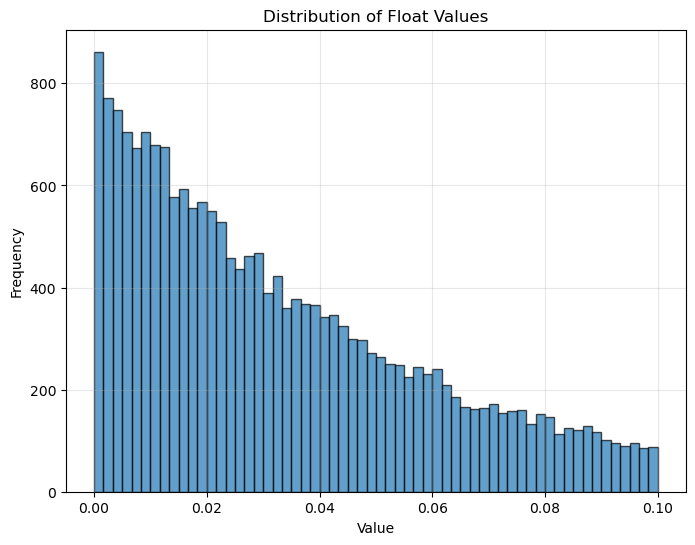

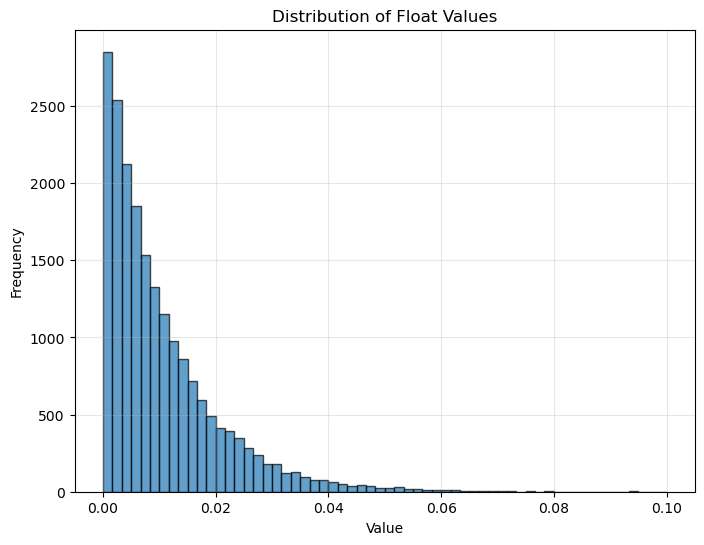

In [34]:
bins = np.linspace(0, UMAX, num=61)
values = []
for i in range(1, 101):
    lines = []
    with open(f"{DIR}/65/{str(i)}.json", "r") as f:
        lines = f.readlines()
    file_values = [t.utilization for t in sc.from_json_setting(lines[0]).tasks]
    values += file_values


plt.figure(figsize=(8, 6))
plt.hist(values, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Float Values')
plt.grid(True, alpha=0.3)
plt.show()

values = []
for i in range(1, 101):
    lines = []
    with open(f"{DIR}/21/{str(i)}.json", "r") as f:
        lines = f.readlines()
    file_values = [t.utilization for t in sc.from_json_setting(lines[0]).tasks]
    values += file_values


plt.figure(figsize=(8, 6))
plt.hist(values, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Float Values')
plt.grid(True, alpha=0.3)
plt.show()

# Simulate the tasksets

In [4]:
for target in targets:
    print(f"-> logs_{alloc}_{sched}_{target}")
    sim.simul(DIR, alloc, sched, PLATFORM, target, f"{DIR}_logs_{alloc}_{sched}_{target}")

print("== finished ==")

-> logs_smart_ass_grub_0.05
-> logs_smart_ass_grub_0.1
-> logs_smart_ass_grub_0.15
-> logs_smart_ass_grub_0.2
== finished ==


-> logs_smart_ass_grub_0.3


-> logs_smart_ass_grub_0.4


-> logs_smart_ass_grub_0.5


-> logs_smart_ass_grub_0.6


# Logs analysis

In [5]:
def compute_stats(logs_dir):
    args = [SCHEDVIEW, "--platform", PLATFORM, "-d", logs_dir, "--index", "--arrivals", "--rejected", "--deadlines-counts", "--cmigration", "--transitions", "--duration"]
    try:
        df_res = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
    except subprocess.CalledProcessError as e:
        print(f"CalledProcessError: {str.join(" ", e.cmd)} | {e.stdout}")
        raise e

    df_res = df_res.with_columns((pl.col("file").str.extract(r"(\w+).json").cast(pl.Int32)).alias("id")).drop("file")
    df_energy = pl.DataFrame({
        "c1-energy": [],
        "c2-energy": []
    }, schema={"c1-energy": pl.Float64, "c2-energy": pl.Float64})
    for i in range(1, 101):
        args = [SCHEDVIEW, "--platform", PLATFORM, f"{logs_dir}/{i}.json", "--index", "--energy"]
        df = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
        df = pl.DataFrame({"c1-energy": df["energy_consumption"][0], "c2-energy": df["energy_consumption"][1]})
        df_energy = pl.concat([df_energy, df])

    df_util = pl.DataFrame({
        "c1-util": [],
        "c2-util": []
    }, schema={"c1-util": pl.Float64, "c2-util": pl.Float64})
    for i in range(1, 101):
        args = [SCHEDVIEW, "--platform", PLATFORM, f"{logs_dir}/{i}.json", "--index", "--util"]
        df = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
        df = pl.DataFrame({"c1-util": df["util"][0], "c2-util": df["util"][1]})
        df_util = pl.concat([df_util, df])

    return pl.concat([df_res, df_energy, df_util], how="horizontal")

stats = {}
for target in targets:
    print(f"-> target {target}")
    stats[target] = {}
    stats_df = []

    def compute_utilization_step(i):
        return compute_stats(f"{DIR}_logs_{alloc}_{sched}_{target}/{i}").with_columns(utilizations=i / 10)

    with ThreadPoolExecutor() as executor:
        stats_df = list(executor.map(compute_utilization_step, util_steps))

    stats[target] = pl.concat(stats_df).select(["utilizations", "id", pl.exclude(["utilizations", "id"])]).sort(["utilizations", "id"])

print("== finished ==")

-> target 0.05


ValueError: cannot concat empty list

In [ ]:
results = {}
for target in targets:
    results[target] = (stats[target].with_columns(
        (1 - (pl.col("rejected") / pl.col("arrivals"))).alias("accepted-rates"),
        (1 - (pl.col("deadlines-counts") / (pl.col("arrivals") - pl.col("rejected")))).alias("meet-rates"),
        (pl.col("cmigration") / pl.col("transitions")).alias("migration-rates"),
        (pl.col("c1-energy") / pl.col("duration")).alias("c1-power"),
        (pl.col("c2-energy") / pl.col("duration")).alias("c2-power"),
        (pl.col("c1-energy") / pl.col("duration") + pl.col("c2-energy") / pl.col("duration")).alias("total-power"),
        (pl.col("c1-util") + pl.col("c2-util")).alias("total-util")
    ).group_by("utilizations").agg(
        pl.col("accepted-rates").mean(),
        pl.col("meet-rates").mean(),
        pl.col("migration-rates").mean(),
        pl.col("c1-power").mean(),
        pl.col("c2-power").mean(),
        pl.col("total-power").mean(),
        pl.col("c1-util").mean(),
        pl.col("c2-util").mean(),
        pl.col("total-util").mean()
    ))

energy = pl.concat([
  stats[t].select(["utilizations", "id", "c1-energy", "c2-energy"]).rename({"c1-energy": f"c1-energy-{str(t)}", "c2-energy": f"c2-energy-{str(t)}"}) for t in targets
], how="align")

energy_diff = energy.with_columns(
    [(pl.col(f"{clu}-energy-{t}") - pl.col(f"{clu}-energy-0.1")).alias(f"{clu}-energy-{t}-diff") for t in targets for clu in ["c1", "c2"]],
).with_columns(
    [(pl.col(f"c1-energy-{target}-diff") + pl.col(f"c2-energy-{target}-diff")).alias(f"energy-{target}-diff") for target in targets]
).group_by("utilizations").agg(
    pl.exclude(["utilizations", "id"]).mean()
)

In [ ]:
energy_diff

In [ ]:
energy_diff.select(pl.col(r"^c1-energy.*diff$")).max().with_columns(pl.max_horizontal("*").alias("max"))["max"]

In [ ]:
# Create a figure with 4 rows and 3 columns
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# First row: Accepted Rates, Deadline Meet Rates, Migration Rates
for t in targets:
    axes[0].plot(results[t]["utilizations"], results[t]["accepted-rates"] * 100, label=f"u target = {t}", marker='s')
axes[0].set_ylim(0, 105)
axes[0].set_xlabel("Utilizations")
axes[0].set_ylabel("Accepted Rates (%)")
axes[0].set_title("Accepted Rates vs Utilizations")
axes[0].legend()
axes[0].grid(True)

for t in targets:
    axes[1].plot(results[t]["utilizations"], results[t]["meet-rates"] * 100, label=f"u target = {t}", marker='s')
axes[1].set_ylim(0, 105)
axes[1].set_xlabel("Utilizations")
axes[1].set_ylabel("Deadline meet Rates (%)")
axes[1].set_title("Deadline meet Rates vs Utilizations")
axes[1].legend()
axes[1].grid(True)

for t in targets:
    axes[2].plot(results[t]["utilizations"], results[t]["migration-rates"] * 100, label=f"u target = {t}", marker='s')
axes[2].set_xlabel("Utilizations")
axes[2].set_ylabel("Migration Rates (%)")
axes[2].set_title("Migration Rates vs Utilizations")
axes[2].legend()
axes[2].grid(True)


max_y = max(energy_diff.select(pl.col(r"^c1-energy.*diff$")).max().with_columns(pl.max_horizontal("*").alias("max"))["max"]) * 1.05
min_y = max(energy_diff.select(pl.col(r"^c1-energy.*diff$")).min().with_columns(pl.min_horizontal("*").alias("min"))["min"]) * 1.10

for t in targets:
    axes[3].plot(energy_diff["utilizations"], energy_diff[f"c1-energy-{t}-diff"], label=f"u target = {t}", marker='s')
axes[3].set_xlabel("Utilizations")
axes[3].set_ylabel("Difference Energy Consumption")
axes[3].set_title("Energy Diff - Big Cluster")
axes[3].set_ylim(min_y, max_y)
axes[3].legend()
axes[3].grid(True)

max_y = max(energy_diff.select(pl.col(r"^c2-energy.*diff$")).max().with_columns(pl.max_horizontal("*").alias("max"))["max"]) * 1.05
min_y = max(energy_diff.select(pl.col(r"^c2-energy.*diff$")).min().with_columns(pl.min_horizontal("*").alias("min"))["min"]) * 1.10
for t in targets:
    axes[4].plot(energy_diff["utilizations"], energy_diff[f"c2-energy-{t}-diff"], label=f"u target = {t}", marker='s')
axes[4].set_xlabel("Utilizations")
axes[4].set_ylabel("Difference Energy Consumption")
axes[4].set_title("Energy Diff - LITTLE Cluster")
axes[4].set_ylim(min_y, max_y)
axes[4].legend()
axes[4].grid(True)

for t in targets:
    axes[5].plot(energy_diff["utilizations"], energy_diff[f"energy-{t}-diff"], label=f"u target = {t}", marker='s')
axes[5].set_xlabel("Utilizations")
axes[5].set_ylabel("Difference Energy Consumption")
axes[5].set_title("Total Energy Difference")
axes[5].set_ylim(min_y, max_y)
axes[5].legend()
axes[5].grid(True)

for t in targets:
    axes[6].plot(results[t]["utilizations"], results[t]["c1-util"], label=f"u target = {t}", marker='s')
axes[6].set_ylim(0, max([results[x]["c1-util"].max() for x in targets]) * 1.05)
axes[6].set_xlabel("Utilizations")
axes[6].set_ylabel("Average Total Utilization")
axes[6].set_title("Big Cluster Utilization")
axes[6].legend()
axes[6].grid(True)

for t in targets:
    axes[7].plot(results[t]["utilizations"], results[t]["c2-util"], label=f"u target = {t}", marker='s')
axes[7].set_ylim(0, max([results[x]["c1-util"].max() for x in targets]) * 1.05)
axes[7].set_xlabel("Utilizations")
axes[7].set_ylabel("Average Total Utilization")
axes[7].set_title("LITTLE Cluster Utilization")
axes[7].legend()
axes[7].grid(True)

for t in targets:
    axes[8].plot(results[t]["utilizations"], results[t]["total-util"], label=f"u target = {t}", marker='s')
axes[8].set_ylim(0, max([results[x]["total-util"].max() for x in targets]) * 1.05)
axes[8].set_xlabel("Utilizations")
axes[8].set_ylabel("Average Total Utilization")
axes[8].set_title("Total Utilization")
axes[8].legend()
axes[8].grid(True)

for t in targets:
    axes[9].plot(results[t]["utilizations"], results[t]["c1-power"], label=f"u target = {t}", marker='s')
axes[9].set_ylim(0, max([results[x]["c1-power"].max() for x in targets]) * 1.05)
axes[9].set_xlabel("Utilizations")
axes[9].set_ylabel("Average Power Consumption")
axes[9].set_title("Power Consumption - Big Cluster")
axes[9].legend()
axes[9].grid(True)

for t in targets:
    axes[10].plot(results[t]["utilizations"], results[t]["c2-power"], label=f"u target = {t}", marker='s')
axes[10].set_ylim(0, max([results[x]["c1-power"].max() for x in targets]) * 1.05)
axes[10].set_xlabel("Utilizations")
axes[10].set_ylabel("Average Power Consumption")
axes[10].set_title("Power Consumption - LITTLE Cluster")
axes[10].legend()
axes[10].grid(True)

for t in targets:
    axes[11].plot(results[t]["utilizations"], results[t]["total-power"], label=f"u target = {t}", marker='s')
axes[11].set_ylim(0, max([results[x]["total-power"].max() for x in targets]) * 1.05)
axes[11].set_xlabel("Utilizations")
axes[11].set_ylabel("Average Power Consumption")
axes[11].set_title("Total Power Consumption")
axes[11].legend()
axes[11].grid(True)

plt.tight_layout()
plt.show()